# Summary
## __Michelle Yilin Feng U93013798__

This notebook summarizes __1. the ways I get data from 5 sources, 2. cleaning data, 3. applying ML models, and 4. automation with Kalshi api__.
At the beginning of each step, detailed explanation and code are provided. 

Regarding the results, I found that statistical forecasting produces the most reasonable outcomes. At least, from my observations, predictions from other models (such as linear regression, ridge regression, or neural networks) are not able to grasp sequential patterns as well as statistical forecasting. Therefore, I used SARIMA (one type of statistical forecasting) to make predictions and submit orders through the Kalshi API.


Regarding the other folders inside the zip folder:
- The __data folder__ contains all the historical data I fetched from the 5 data sources.
- The __API folder__ stores the code that I actually used to fetch all the historical data; I copied them to part 1 for clarity.
- The __aggregate folder__ contains the CSV for the aggregation of specific features for a city that I created in part 2, step 1.
- The __other four CSVs__ located in the root directory (austin_aggregate.csv, etc.) are the final CSVs that I used to train models.
- the __utility.py__ stores some helper function used by the files inside API folder
- the __KalshiScreenShot__ folder stores the image for screenshots that are displayed in the following


Here are the screenshots of Kalshi activity for each week. I cannot find a better way to show my account balance, but the earnings in the bottom right corner should provide some insight into the accuracy of my predictions.

![alt text](ScreenShot/KalshiWeek1.png)
![KalshiWeek3 screenshot](ScreenShot/KalshiWeek2.png)
![KalshiWeek3 screenshot](ScreenShot/KalshiWeek3.png)


Possible Reasons Why the Earnings Are 0 for 3/28 and 3/30:

- The data is not up to date.
I used to statistical forecasting (SARIMA and Exponential Smoothing) to predict the temperature. The historical data ranges only from 04-01-2023 to 03-24-2024. Therefore, the earnings for the days closer to 03-24-2024 are higher compared to the days that are farther away.

# Part 3: Appy ML models

- I implemented some basic ML models (linear regression, ridge regression, etc.) and realized they are not very effective in predicting results for a specific day.
- I then switched to statistical forecasting (SARIMA and Exponential Smoothing) and discovered that they are very proficient at predicting the highest temperature for a day. Specifically, the historical data ranges from 04-01-2023 to 03-24-2024. If I want to predict the highest temperature for 03-26-2024, it's not necessary to update the historical data up to 03-25-2024 to make a prediction. Of course, the prediction would not be as accurate compared to if I updated the historical dataset. However, the performance is significantly better than the other models I have tried.

# Part 0: install dependencies and read csv files


In [1]:
# !pip install openmeteo_requests
# !pip install requests_cache
# !pip install retry_requests
# !pip install tensorflow
# !pip install pandas
# !pip install requests

In [2]:
import pandas as pd
from datetime import datetime, timedelta

# for saving files as csv
import os
import requests
import pandas as pd
import datetime
import openmeteo_requests
import requests_cache
from retry_requests import retry

# Part 1. Get Data From 5 Data Sources
- I was able to obtain data from five sources: Weather API, OpenMeteo, OpenWeather, World Weather Online, and Virtual Crossing. For all sources except OpenMeteo (due to free tier limitations), the data I fetched ranges from 2023-04-01 to 2024-03-24. For all sources except Virtual Crossing, I obtained the data by using their API. For Virtual Crossing, they offer an online UI to send API requests, and I have obtained a screenshot of how that looks in the following section.

- The historical data fetched was stored in the data folder.

In [3]:
def save_to_csv(df, filename, path):
    """
      save a pandas DataFrame (df) to a CSV file, with the flexibility to either create a new file or append to an existing one.
    """
    current_script_path = os.path.dirname(os.path.abspath(__file__))
    full_dir_path = os.path.join(current_script_path, '..', path)
    if not os.path.exists(full_dir_path):
        os.makedirs(full_dir_path)
    full_file_path = os.path.join(full_dir_path, filename)
    file_exists = os.path.isfile(full_file_path)
    df.to_csv(full_file_path, mode='a' if file_exists else 'w', header=not file_exists, index=False)

## 1. weatherApi https://www.weatherapi.com/docs/

- Due to the limitation on the number of API requests I can send, I have saved data from **2023-04-01** up to the present.
- I use getAllHistory to fetch information from April 1, 2023, to March 17, 2024. For the subsequent days, I use getDailyUpdate to obtain new data.
This applies to other sources


In [4]:
def weatherApi_history(zipcode,date,city):
    """
      retrieves and saves historical weather data for a specified location and date
    """

    url = "http://api.weatherapi.com/v1/history.json"
    parameters = {
        "key": "placeholder",
        "q": zipcode,
        "dt": date,
    }
    response = requests.get(url, params=parameters)
    if response.status_code == 200:
        data = response.json()
        print(data)
        forecast_df = pd.json_normalize(data['forecast']['forecastday'], sep='_')
        filename = f"{city}_weatherApi.csv"
        save_to_csv(forecast_df, filename,path="data/weatherApi")
    else:
        print(f"Error: {response.status_code}, {response.text}")

def weatherApi_getAllHistory(zipcode,city):
    """
      iterates over a defined date range to collect weather data for a particular location
    """
    start_date = datetime.date(2023, 4, 1)
    end_date = datetime.date(2024, 3, 17)
    current_date = start_date

    while current_date <= end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        weatherApi_history(zipcode, date_str, city)
        current_date += datetime.timedelta(days=1)

def weatherApi_getDailyUpdate(date):
    """
      fetches and updates daily weather data for multiple predefined locations
    """
    weatherApi_history(10023,date,"ny")
    weatherApi_history(78719,date,"austin")
    weatherApi_history(33142,date,"miami")
    weatherApi_history(60638,date,"chicago")

## 2. OpenMetero https://open-meteo.com/en/docs/

- Due to the availability of historical data that OpenMeteo provides, I have saved data from **October 11, 2023**, up to the present.

In [5]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def getOpenMeteo(lat,lon,city,startDate,endDate):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "uv_index_max", "uv_index_clear_sky_max", "precipitation_sum", "rain_sum", "showers_sum", "snowfall_sum", "precipitation_hours", "precipitation_probability_max", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration"],
        "timezone": "America/New_York",
        "start_date": startDate,
        "end_date": endDate
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_weather_code = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
    daily_apparent_temperature_max = daily.Variables(3).ValuesAsNumpy()
    daily_apparent_temperature_min = daily.Variables(4).ValuesAsNumpy()
    daily_sunrise = daily.Variables(5).ValuesAsNumpy()
    daily_sunset = daily.Variables(6).ValuesAsNumpy()
    daily_daylight_duration = daily.Variables(7).ValuesAsNumpy()
    daily_sunshine_duration = daily.Variables(8).ValuesAsNumpy()
    daily_uv_index_max = daily.Variables(9).ValuesAsNumpy()
    daily_uv_index_clear_sky_max = daily.Variables(10).ValuesAsNumpy()
    daily_precipitation_sum = daily.Variables(11).ValuesAsNumpy()
    daily_rain_sum = daily.Variables(12).ValuesAsNumpy()
    daily_showers_sum = daily.Variables(13).ValuesAsNumpy()
    daily_snowfall_sum = daily.Variables(14).ValuesAsNumpy()
    daily_precipitation_hours = daily.Variables(15).ValuesAsNumpy()
    daily_precipitation_probability_max = daily.Variables(16).ValuesAsNumpy()
    daily_wind_speed_10m_max = daily.Variables(17).ValuesAsNumpy()
    daily_wind_gusts_10m_max = daily.Variables(18).ValuesAsNumpy()
    daily_wind_direction_10m_dominant = daily.Variables(19).ValuesAsNumpy()
    daily_shortwave_radiation_sum = daily.Variables(20).ValuesAsNumpy()
    daily_et0_fao_evapotranspiration = daily.Variables(21).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}
    daily_data["weather_code"] = daily_weather_code
    daily_data["temperature_2m_max"] = daily_temperature_2m_max
    daily_data["temperature_2m_min"] = daily_temperature_2m_min
    daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
    daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
    daily_data["sunrise"] = daily_sunrise
    daily_data["sunset"] = daily_sunset
    daily_data["daylight_duration"] = daily_daylight_duration
    daily_data["sunshine_duration"] = daily_sunshine_duration
    daily_data["uv_index_max"] = daily_uv_index_max
    daily_data["uv_index_clear_sky_max"] = daily_uv_index_clear_sky_max
    daily_data["precipitation_sum"] = daily_precipitation_sum
    daily_data["rain_sum"] = daily_rain_sum
    daily_data["showers_sum"] = daily_showers_sum
    daily_data["snowfall_sum"] = daily_snowfall_sum
    daily_data["precipitation_hours"] = daily_precipitation_hours
    daily_data["precipitation_probability_max"] = daily_precipitation_probability_max
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
    daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
    daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum
    daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration

    daily_dataframe = pd.DataFrame(data = daily_data)
    filename = f"{city}_openMeteo.csv"
    save_to_csv(daily_dataframe, filename,path="data/openMeteo")

def openMeteo_getHistoricDate(startDate,endDate):
    getOpenMeteo(40.77373,-73.98007,"ny",startDate,endDate)
    getOpenMeteo(30.14440,-97.66876,"austin",startDate,endDate)
    getOpenMeteo(25.81253,-80.24044,"miami",startDate,endDate)
    getOpenMeteo(41.78701,-87.77166,"chicago",startDate,endDate)

def openMeteo_getDailyUpdate(date):
    getOpenMeteo(40.7128,-74.0060,"ny",date,date)
    getOpenMeteo(30.14440,-97.66876,"austin",date,date)
    getOpenMeteo(25.81253,-80.24044,"miami",date,date)
    getOpenMeteo(41.78701,-87.77166,"chicago",date,date)

## 3. OpenWeather https://openweathermap.org/api/one-call-3

- Due to the limitation on the number of API requests I can send, I have saved data from **2023-04-01** up to the present.

In [6]:
api_key = 'placeholder'

def getOpenWeather(lat,lon,city,date):
    units = 'metric'
    # Construct the URL with the parameters
    url = f'https://api.openweathermap.org/data/3.0/onecall/day_summary?lat={lat}&lon={lon}&date={date}&units={units}&appid={api_key}'
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        df = pd.json_normalize([data])
        filename = f"{city}_openWeather.csv"
        df.to_csv(filename, index=False)
    else:
        print(f"Error: {response.status_code}, {response.text}")

def openWeather_getAllHistory(lat,lon,city):
    start_date = datetime(2023, 4, 1)
    end_date = datetime(2024, 3, 17)
    current_date = start_date

    while current_date <= end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        getOpenWeather(lat,lon,city,date_str)
        current_date += timedelta(days=1)

def openWeather_getDailyUpdate(date):
    getOpenWeather(40.77373,-73.98007,"ny",date)
    getOpenWeather(30.14440,-97.66876,"austin",date)
    getOpenWeather(25.81253,-80.24044,"miami",date)
    getOpenWeather(41.78701,-87.77166,"chicago",date)

## 4. World Weather Online https://www.worldweatheronline.com/weather-api/api/docs/historical-weather-api.aspx


In [7]:

# Your API key from World Weather Online
api_key = 'placeholder'

def wordWeatherApi(q,date,city):
    base_url = "https://api.worldweatheronline.com/premium/v1/past-weather.ashx"
    params = {
        "q": q,
        "date": date,
        "tp": "1",
        "format": "json",
        "key": api_key,
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.json_normalize([data['data']['weather'][0]])

        filename = f"{city}_worldWeatherOnline.csv"
        save_to_csv(df, filename,path="data/worldWeatherOnline")
    else:
        print("Failed to retrieve data:", response.status_code)

def worldWeatherOnline_saveAllHistory(q,city):
    start_date = datetime(2023, 4, 1)
    end_date = datetime(2024, 3, 17)
    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        wordWeatherApi(q,city,date_str)
        current_date += timedelta(days=1)

def worldWeatherOnline_getDailyUpdate(date):
    wordWeatherApi(10023,date,"ny")
    wordWeatherApi(78719,date,"austin")
    wordWeatherApi(33142,date,"miami")
    wordWeatherApi(60638,date,"chicago")

## 5. Virtual Crossing https://www.visualcrossing.com/weather-data

 - can be directly downloaded from website

 - Due to the limitation on the number of API requests I can send, I have saved data from **2023-04-01** up to the present.


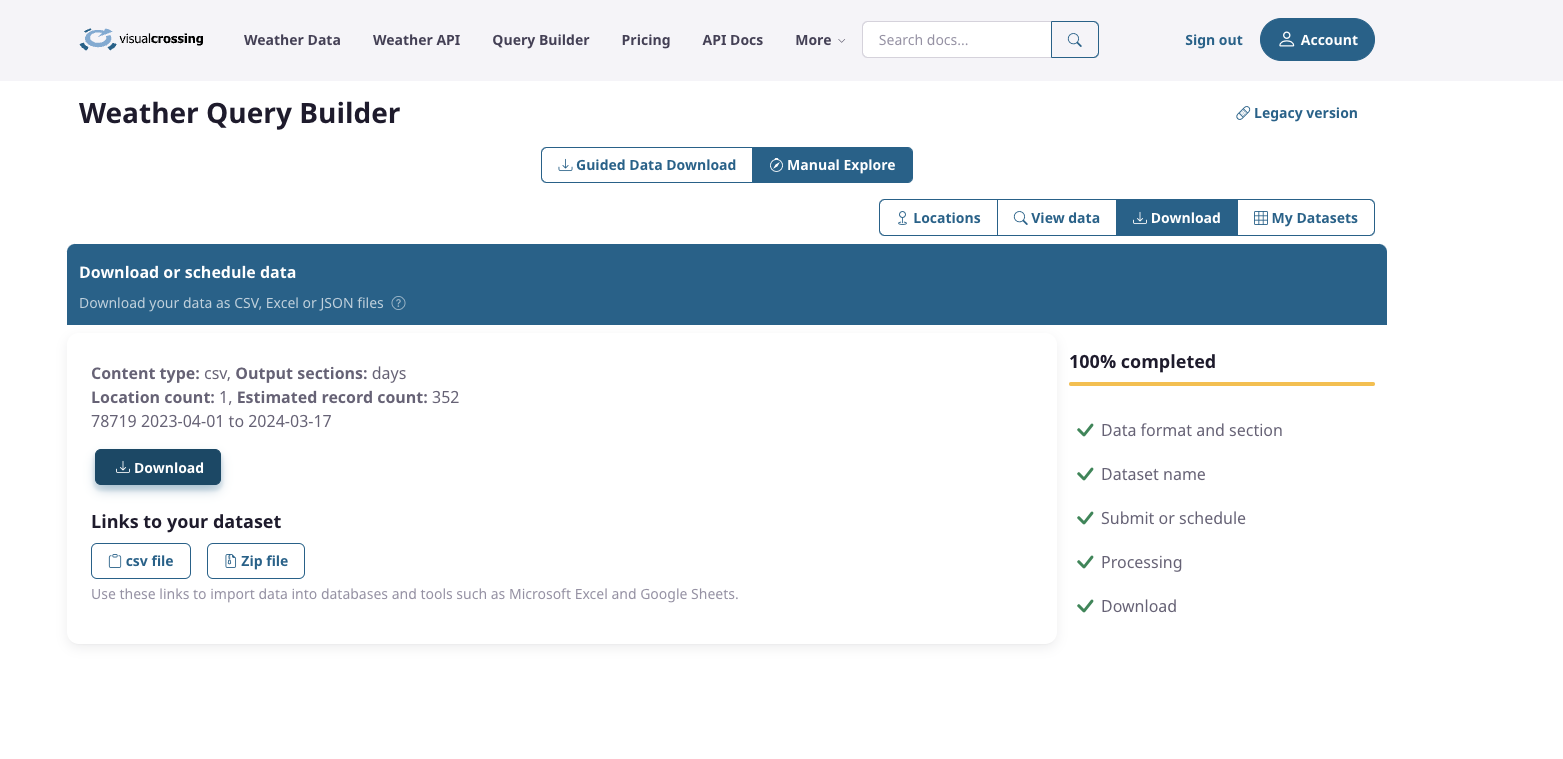

# Part 2: Cleaning Data

## Step 1: Renaming Every Feature + Creating CSVs for Every Feature

### challenge 1: different naming for same feature among different sources
From every data source, I renamed their features to match the final one.

- For example: Different sources may have different names for the same feature (e.g., "temperature_2m_max", "day_maxtemp_c", "tempmax", "temperature.max", "maxtempC"). I renamed them into "max_temp"

### challenge 2: differnt unit for the same features among different sources

I make sure that the unit accorss every sources are align

- For example, for windspeed unit, since source beside openWeather are using kph instead of mps, I convert openWeather's result to kph

Once features are renamed, I create separate CSV files for each feature, putting the data into them.

- Each CSV file will contain the data for a single feature from all sources. The csv files are stored under the aggregate folder


### Challenge 3: Incorrect outcomes encountered when handling features with datetime information, such as sunset and sunrise.
The feature I selected are the maximum temperature, minimum temperature, maximum apparent temperature, minimum apparent temperature, time for sun rise, time for sun set, total precipitation, and wind speed

- I ended up removing the times for sunrise and sunset because their formats are a bit different. I tried to calculate the mean time from all sources and convert them into numerical values for models to accept. However, this process resulted in obviously incorrect outcomes.

![picture for conversion example](ScreenShot/sunriseSet.png)

As you can see in the picture, I calculate the mean of the datetime values for sunset and sunrise, and then convert them to numerical values. I then convert them to a readable date format and realize that they are significantly incorrect. For example, in the second row, the data is for 4/2, but the sunset time is 4/1.

In [2]:
"""
    code that create the aggregate csv files for each feature
"""
def create_max_temp_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city):
    # rename all col to: max_temp
    openMeteo = openMeteo.rename(columns={"temperature_2m_max": "openMeteo_max_temp"})
    weatherApi = weatherApi.rename(columns={"day_maxtemp_c": "weatherApi_max_temp"})
    virtualCrossing = virtualCrossing.rename(columns={"tempmax": "virtualCrossing_max_temp"})
    openWeather = openWeather.rename(columns={"temperature.max": "openWeather_max_temp"})
    worldWeather = worldWeather.rename(columns={"maxtempC": "worldWeather_max_temp"})

    # only concatenate the max_temp col
    max_temp_aggregate = pd.concat([
        openMeteo['openMeteo_max_temp'],
        weatherApi['weatherApi_max_temp'],
        virtualCrossing['virtualCrossing_max_temp'],
        openWeather['openWeather_max_temp'],
        worldWeather['worldWeather_max_temp']
    ], axis=1)

    filename = f"aggregate/{city}_max_temp_aggregate.csv"
    max_temp_aggregate.to_csv(filename, index=True)
    # print(max_temp_aggregate)


def create_min_temp_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city):
    # rename all col to: min_temp
    openMeteo = openMeteo.rename(columns={"temperature_2m_min": "openMeteo_min_temp"})
    weatherApi = weatherApi.rename(columns={"day_mintemp_c": "weatherApi_min_temp"})
    virtualCrossing = virtualCrossing.rename(columns={"tempmin": "virtualCrossing_min_temp"})
    openWeather = openWeather.rename(columns={"temperature.min": "openWeather_min_temp"})
    worldWeather = worldWeather.rename(columns={"mintempC": "worldWeather_min_temp"})

    # only concatenate the max_temp col
    max_temp_aggregate = pd.concat([
        openMeteo['openMeteo_min_temp'],
        weatherApi['weatherApi_min_temp'],
        virtualCrossing['virtualCrossing_min_temp'],
        openWeather['openWeather_min_temp'],
        worldWeather['worldWeather_min_temp']
    ], axis=1)

    filename = f"aggregate/{city}_min_temp_aggregate.csv"
    max_temp_aggregate.to_csv(filename, index=True)
    # print(max_temp_aggregate)


def create_max_temp_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city):
    # rename all col to: max_temp
    openMeteo = openMeteo.rename(columns={"temperature_2m_max": "openMeteo_max_temp"})
    weatherApi = weatherApi.rename(columns={"day_maxtemp_c": "weatherApi_max_temp"})
    virtualCrossing = virtualCrossing.rename(columns={"tempmax": "virtualCrossing_max_temp"})
    openWeather = openWeather.rename(columns={"temperature.max": "openWeather_max_temp"})
    worldWeather = worldWeather.rename(columns={"maxtempC": "worldWeather_max_temp"})

    # only concatenate the max_temp col
    max_temp_aggregate = pd.concat([
        openMeteo['openMeteo_max_temp'],
        weatherApi['weatherApi_max_temp'],
        virtualCrossing['virtualCrossing_max_temp'],
        openWeather['openWeather_max_temp'],
        worldWeather['worldWeather_max_temp']
    ], axis=1)

    filename = f"aggregate/{city}_max_temp_aggregate.csv"
    max_temp_aggregate.to_csv(filename, index=True)
    # print(max_temp_aggregate)

def create_max_apparent_temp_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city):
    # rename all col to: apparent_temp: only 2 sources have this information
    openMeteo = openMeteo.rename(columns={"apparent_temperature_max": "openMeteo_max_apparent_temp"})
    virtualCrossing = virtualCrossing.rename(columns={"feelslikemax": "virtualCrossing_max_apparent_temp"})

    colName="_max_apparent_temp"
    # only concatenate the max_temp col
    max_temp_aggregate = pd.concat([
        openMeteo[f'openMeteo{colName}'],
        virtualCrossing[f'virtualCrossing{colName}'],
    ], axis=1)

    filename = f"aggregate/{city}{colName}_aggregate.csv"
    max_temp_aggregate.to_csv(filename, index=True)

def create_min_apparent_temp_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city):
    # rename all col to: apparent_temp: only 2 sources have this information
    openMeteo = openMeteo.rename(columns={"apparent_temperature_min": "openMeteo_min_apparent_temp"})
    virtualCrossing = virtualCrossing.rename(columns={"feelslikemin": "virtualCrossing_min_apparent_temp"})

    colName="_min_apparent_temp"
    # only concatenate the max_temp col
    max_temp_aggregate = pd.concat([
        openMeteo[f'openMeteo{colName}'],
        virtualCrossing[f'virtualCrossing{colName}'],
    ], axis=1)

    filename = f"aggregate/{city}{colName}_aggregate.csv"
    max_temp_aggregate.to_csv(filename, index=True)

def create_sun_rise_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city):
    colName = "_mean_sunrise"
    # rename all col to: mean_sunrise: only 2 sources have this information
    # since averaging days formate is hard and it is unecessary to do this because both sources gives similar data, we just select one
    weatherApi = weatherApi.rename(columns={"astro_sunrise": "mean_sunrise"})
    sunrise_aggregate = pd.concat([
        weatherApi['mean_sunrise'],
    ], axis=1)
    filename = f"aggregate/{city}{colName}_aggregate.csv"
    sunrise_aggregate.to_csv(filename, index=True)

def create_sun_set_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city):
    colName = "_mean_sunset"
    virtualCrossing = virtualCrossing.rename(columns={"sunset": "mean_sunset"})
    sunrise_aggregate = pd.concat([
        virtualCrossing['mean_sunset'],
    ], axis=1)
    filename = f"aggregate/{city}{colName}_aggregate.csv"
    sunrise_aggregate.to_csv(filename, index=True)

def create_total_precipitation_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city):
    colName="_total_precipitation"
    # rename all col to: total_precipitation: only 4 sources have this information
    openMeteo = openMeteo.rename(columns={"precipitation_sum": f"openMeteo{colName}"})
    virtualCrossing = virtualCrossing.rename(columns={"precip": f"virtualCrossing{colName}"})
    openWeather = openWeather.rename(columns={"precipitation.total": f"openWeather{colName}"})
    weatherApi = weatherApi.rename(columns={"day_totalprecip_mm": f"weatherApi{colName}"})

    total_precipitation_aggregate = pd.concat([
        openMeteo[f'openMeteo{colName}'],
        virtualCrossing[f'virtualCrossing{colName}'],
        openWeather[f'openWeather{colName}'],
        weatherApi[f'weatherApi{colName}'],
    ], axis=1)

    filename = f"aggregate/{city}{colName}_aggregate.csv"
    total_precipitation_aggregate.to_csv(filename, index=True)

def create_wind_speed_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city):
    colName="_wind_speed"
    # rename all col to: wind_speed: only 4 sources have this information
    openMeteo = openMeteo.rename(columns={"wind_speed_10m_max": f"openMeteo{colName}"})
    virtualCrossing = virtualCrossing.rename(columns={"windspeed": f"virtualCrossing{colName}"})
    openWeather = openWeather.rename(columns={"wind.max.speed": f"openWeather{colName}"})
    weatherApi = weatherApi.rename(columns={"day_maxwind_kph": f"weatherApi{colName}"})

    # convert m/s to km/h
    openWeather[f"openWeather{colName}"] = openWeather[f"openWeather{colName}"] * 3.6

    wind_speed_aggregate = pd.concat([
        openMeteo[f'openMeteo{colName}'],
        virtualCrossing[f'virtualCrossing{colName}'],
        openWeather[f'openWeather{colName}'],
        weatherApi[f'weatherApi{colName}'],
    ], axis=1)

    filename = f"aggregate/{city}{colName}_aggregate.csv"
    wind_speed_aggregate.to_csv(filename, index=True)



## Step 2: Calculating the Mean of the Columns Inside CSVs + Creating the Aggregate DataFrame
For each CSV file, I calculate the mean of the columns. 

- This involves reading each CSV, computing the mean of each column, and storing the mean values.

I then create an aggregate dataframe to combine the mean values of all features from different sources. The csv files is stored inside the aggregate directory

- Each row in the aggregate dataframe will represent the mean values of all features across different sources.

In [1]:
def getAllCsv(city):
    openMeteo = pd.read_csv(f'data/openMeteo/{city}_openMeteo.csv')
    weatherApi = pd.read_csv(f'data/weatherApi/{city}_weatherApi.csv')
    virtualCrossing = pd.read_csv(f'data/virtualCrossing/{city}_virtualCrossing.csv')
    openWeather = pd.read_csv(f'data/openWeather/{city}_openWeather.csv')
    worldWeather = pd.read_csv(f'data/worldWeatherOnline/{city}_worldWeatherOnline.csv')
    return openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather

In [41]:
def create_all_data_cvs(city):
    openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather = getAllCsv(city)

    ## rename date + ensure consistant formatting
    virtualCrossing = virtualCrossing.rename(columns={"datetime": "date"})
    openMeteo['date'] = pd.to_datetime(openMeteo['date']).dt.strftime('%Y-%m-%d')

    openMeteo.set_index('date', inplace=True)
    weatherApi.set_index('date', inplace=True)
    virtualCrossing.set_index('date', inplace=True)
    openWeather.set_index('date', inplace=True)
    worldWeather.set_index('date', inplace=True)


    # When adding data, there's a risk of inadvertently adding the same day
    # twice, such as by running the code multiple times. Since the date is set
    # as the index, having duplicates could lead to problems, making it prudent
    # to verify and address any duplicate keys.
    data_frames = {
    'worldWeather': worldWeather,
    'openWeather': openWeather,
    'virtualCrossing': virtualCrossing,
    'weatherApi': weatherApi,
    'openMeteo': openMeteo
    }

    for name, df in data_frames.items():
        has_duplicates = df.index.duplicated().any()
        if has_duplicates:
            print(f"{name} has duplicates: {has_duplicates}")
            duplicate_rows = df[df.duplicated()]
            print(duplicate_rows)
        else:
            pass

    ## creating csv files for each important col
    create_max_temp_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city)
    create_min_temp_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city)
    create_max_apparent_temp_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city)
    create_min_apparent_temp_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city)
    create_sun_rise_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city)
    create_sun_set_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city)

    create_total_precipitation_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city)
    create_wind_speed_csv(openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather,city)

def create_aggregate_average_csv(city):
    # create csv with individual features that we need
    create_all_data_cvs(city)

    # get access to the csv files
    max_temp = pd.read_csv(f'aggregate/{city}_max_temp_aggregate.csv',index_col='date')
    min_temp = pd.read_csv(f'aggregate/{city}_min_temp_aggregate.csv',index_col='date')
    max_apprent_temp = pd.read_csv(f'aggregate/{city}_max_apparent_temp_aggregate.csv',index_col='date')
    min_apparent_temp = pd.read_csv(f'aggregate/{city}_min_apparent_temp_aggregate.csv',index_col='date')
    sunrise = pd.read_csv(f'aggregate/{city}_mean_sunrise_aggregate.csv',index_col='date')
    sunset = pd.read_csv(f'aggregate/{city}_mean_sunset_aggregate.csv',index_col='date')
    total_precipitation = pd.read_csv(f'aggregate/{city}_total_precipitation_aggregate.csv',index_col='date')
    wind_speed = pd.read_csv(f'aggregate/{city}_wind_speed_aggregate.csv',index_col='date')

    # getting the min of each value
    max_temp_mean = max_temp.mean(axis=1, skipna=True).to_frame(name='mean_max_temp')
    min_temp_mean = min_temp.mean(axis=1, skipna=True).to_frame(name='mean_min_temp')
    max_apprent_temp_mean = max_apprent_temp.mean(axis=1, skipna=True).to_frame(name='mean_max_apparent_temp')
    min_apparent_temp_mean = min_apparent_temp.mean(axis=1, skipna=True).to_frame(name='mean_min_apparent_temp')
    sunrise_mean = sunrise
    sunset_mean = sunset
    total_precipitation_mean = total_precipitation.mean(axis=1, skipna=True).to_frame(name='mean_total_precipitation')
    wind_speed_mean = wind_speed.mean(axis=1, skipna=True).to_frame(name='mean_wind_speed')

    # form the aggregate average csv
    # sunrise_mean, sunset_mean are temporarily removed because they are in string format
    aggregate = pd.concat([max_temp_mean, min_temp_mean,max_apprent_temp_mean,min_apparent_temp_mean,total_precipitation_mean,wind_speed_mean], axis=1)

    aggregate_csv = aggregate.to_csv(f'{city}_aggregate.csv', index=True, index_label='date')
    return aggregate

In [44]:
def getAllCsv(city):
    openMeteo = pd.read_csv(f'data/openMeteo/{city}_openMeteo.csv')
    weatherApi = pd.read_csv(f'data/weatherApi/{city}_weatherApi.csv')
    virtualCrossing = pd.read_csv(f'data/virtualCrossing/{city}_virtualCrossing.csv')
    openWeather = pd.read_csv(f'data/openWeather/{city}_openWeather.csv')
    worldWeather = pd.read_csv(f'data/worldWeatherOnline/{city}_worldWeatherOnline.csv')
    return openMeteo, weatherApi, virtualCrossing, openWeather, worldWeather

## Step 3: Generate the Final Aggregate DataFrame
- This Aggregate DataFrame consolidates averaged data from five distinct sources and includes the five features I have selected from all sources. These features are: minimum temperature (min_temp), maximum apparent temperature (max_apparent_temp), minimum apparent temperature (min_apparent_temp), total precipitation (total_precipitation), and wind speed.

The csv files is stored inside the root directory (eg: ny_aggregate.csv)

In [46]:
ny_aggregate = create_aggregate_average_csv("ny")
chicago_aggregate = create_aggregate_average_csv("chicago")
austin_aggregate = create_aggregate_average_csv("austin")
miami_aggregate = create_aggregate_average_csv("miami")

print(chicago_aggregate)

            mean_max_temp  mean_min_temp  mean_max_apparent_temp  \
date                                                               
2023-04-01      14.010000         1.7025               12.200000   
2023-04-02      12.752500        -0.7725               13.300000   
2023-04-03      15.825000         6.0925               16.100000   
2023-04-04      19.742500         6.0925               21.100000   
2023-04-05      21.717500         7.6975               22.800000   
...                   ...            ...                     ...   
2024-03-20       8.255000         0.3825                3.210167   
2024-03-21       4.172500        -1.5050                1.743288   
2024-03-22       6.296667         0.1700                0.377850   
2024-03-23       3.125000        -0.9150               -1.391434   
2024-03-24       8.520000        -0.0800                3.738881   

            mean_min_apparent_temp  mean_total_precipitation  mean_wind_speed  
date                               

# Part 3: Appy ML models

- I implemented some basic ML models (linear regression, ridge regression, etc.) and realized they are not very effective in predicting results for a specific day.
- I then switched to statistical forecasting (SARIMA and Exponential Smoothing) and discovered that they are very proficient at predicting the highest temperature for a day. Specifically, the historical data ranges from 04-01-2023 to 03-24-2024. If I want to predict the highest temperature for 03-26-2024, it's not necessary to update the historical data up to 03-25-2024 to make a prediction. Of course, the prediction would not be as accurate compared to if I updated the historical dataset. However, the performance is significantly better than the other models I have tried.

## Step 0: Some Import Statements and Helper Functions

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

/Users/feng/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
def celsius_to_fahrenheit(celsius):
    return celsius * 9/5 + 32

In [14]:
temp_ranges = {0:"62° or below", 1:"63° to 64°", 2:"65° to 66°", 3:"67° to 68°", 4:"69° to 70°", 5:"71° or above"}

def classify_temperature(mean_temp):
    if mean_temp <= 62:
        return 0
    elif 63 <= mean_temp <= 64:
        return 1
    elif 65 <= mean_temp <= 66:
        return 2
    elif 67 <= mean_temp <= 68:
        return 3
    elif 69 <= mean_temp <= 70:
        return 4
    else:
        return 5

def majority_classification(predictions):
    counts = {temp_range: 0 for temp_range in temp_ranges}
    for prediction in predictions:
        counts[prediction] += 1
    return max(counts, key=counts.get)

## Step 1: Basic Models
- not very helpful

In [15]:
def evaluate_models(dataframe, city_name):
    X = dataframe.drop(columns=["mean_max_temp"])
    y = dataframe["mean_max_temp"].apply(celsius_to_fahrenheit)  # Convert y values to Fahrenheit first

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(),
        'Gradient Boosting': GradientBoostingRegressor(),
        'Support Vector Machine': SVR(),
        'K-Nearest Neighbors': KNeighborsRegressor()
    }
    print(f"\nCity: {city_name}")

    model_classifications = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mean_pred_fahrenheit = np.mean(y_pred)
        classification = classify_temperature(mean_pred_fahrenheit)

        # print(f"{name}: Mean prediction in Fahrenheit = {mean_pred_fahrenheit:.2f}, Classified as {temp_ranges[classification]}")
        model_classifications.append(classification)

    # Majority classification
    majority_class = majority_classification(model_classifications)
    print(f"Representative prediction for {city_name}: Classified as {temp_ranges[majority_class]}")

In [16]:
evaluate_models(ny_aggregate, "New York")
evaluate_models(chicago_aggregate, "Chicago")
evaluate_models(austin_aggregate, "Austin")
evaluate_models(miami_aggregate, "Miami")


City: New York
Representative prediction for New York: Classified as 71° or above

City: Chicago
Representative prediction for Chicago: Classified as 63° to 64°

City: Austin
Representative prediction for Austin: Classified as 71° or above

City: Miami
Representative prediction for Miami: Classified as 71° or above


## Step 2: Statistical forecasting

### Sarima
- used this for submitting **orders**

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

def SARIMA(df, city, predicted_date):
    df.index = pd.DatetimeIndex(df.index).to_period('D')

    # Fit a SARIMA model
    sarima_model = SARIMAX(df['mean_max_temp'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_result = sarima_model.fit(disp=False)

    # Calculate the number of days to forecast
    last_date = df.index.max().to_timestamp()  # Convert to timestamp to perform datetime subtraction
    target_date = pd.to_datetime(predicted_date)
    steps = (target_date - last_date).days

    # Forecast for the required number of days
    forecast = sarima_result.get_forecast(steps=steps)
    predicted_temps = forecast.predicted_mean

    # Get the forecasted temperature for the target date
    predicted_temp = predicted_temps[-1]  # Last value is the target date prediction
    predicted_temp_fahrenheit = celsius_to_fahrenheit(predicted_temp)

    print(f"City: {city}")
    print(f"Predicted highest temperature for {target_date.strftime('%Y-%m-%d')}: {predicted_temp_fahrenheit}°F")

    return predicted_temp_fahrenheit

In [38]:
ny_aggregate = create_aggregate_average_csv("ny")
chicago_aggregate = create_aggregate_average_csv("chicago")
austin_aggregate = create_aggregate_average_csv("austin")
miami_aggregate = create_aggregate_average_csv("miami")

SARIMA(ny_aggregate, "New York","2024-03-26")
SARIMA(chicago_aggregate, "Chicago","2024-03-26")
SARIMA(austin_aggregate, "Austin","2024-03-26")
SARIMA(miami_aggregate, "Miami","2024-03-26")

City: New York
Predicted highest temperature for 2024-03-26: 48.246463122609505°F
City: Chicago
Predicted highest temperature for 2024-03-26: 51.001582854427554°F
City: Austin
Predicted highest temperature for 2024-03-26: 72.5012849942897°F
City: Miami
Predicted highest temperature for 2024-03-26: 77.98719366664133°F


77.98719366664133

### Exponential Smoothing

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
def exponentialSmoothing(df, city, predicted_date):
  if not isinstance(df.index, pd.DatetimeIndex):
      df.index = pd.to_datetime(df.index)  # Convert index to DatetimeIndex if not already
  df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq='D'), fill_value=np.nan)

  # Fit the Exponential Smoothing model
  exp_smoothing_model = ExponentialSmoothing(df['mean_max_temp'], trend='add', seasonal='add', seasonal_periods=12)
  exp_smoothing_result = exp_smoothing_model.fit()

  # Calculate the number of days to forecast
  last_date = df.index[-1]
  target_date = pd.to_datetime(predicted_date)
  steps = (target_date - last_date).days

  # Forecast for the required number of days
  forecast = exp_smoothing_result.forecast(steps=steps)
  forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq='D')
  forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast_temp': forecast})

  # Get the forecasted temperature for the target date
  predicted_temp = forecast_df.loc[forecast_df['date'] == target_date, 'forecast_temp'].values[0]
  predicted_temp_fahrenheit = celsius_to_fahrenheit(predicted_temp)

  print(f"City: {city}")
  print(f"Predicted highest temperature for {target_date.strftime('%Y-%m-%d')}: {predicted_temp_fahrenheit}°F")
  return predicted_temp_fahrenheit

In [20]:
ny_aggregate = create_aggregate_average_csv("ny")
chicago_aggregate = create_aggregate_average_csv("chicago")
austin_aggregate = create_aggregate_average_csv("austin")
miami_aggregate = create_aggregate_average_csv("miami")

exponentialSmoothing(ny_aggregate, "New York","2024-03-26")
exponentialSmoothing(chicago_aggregate, "Chicago","2024-03-26")
exponentialSmoothing(austin_aggregate, "Austin","2024-03-26")
exponentialSmoothing(miami_aggregate, "Miami","2024-03-26")

City: New York
Predicted highest temperature for 2024-03-26: 47.24742640819551°F
City: Chicago
Predicted highest temperature for 2024-03-26: 49.08734860871222°F
City: Austin
Predicted highest temperature for 2024-03-26: 73.01778183742468°F
City: Miami
Predicted highest temperature for 2024-03-26: 76.94753398970391°F


76.94753398970391

## Step 3: Neural Network
- more helpful than basic models but still less effective than statistical forecasting






In [21]:
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# """
# The Kernel crashed while executing code in the current cell or a previous cell. 
# Please review the code in the cell(s) to identify a possible cause of the failure. 
# Click here for more info. 
# View Jupyter log for further details."""

In [22]:
def neuralNet(df,city):
  # Normalize your data
  scaler = MinMaxScaler(feature_range=(0, 1))
  data_scaled = scaler.fit_transform(ny_aggregate['mean_max_temp'].values.reshape(-1,1))

  # Parameters
  n_input = 14
  n_features = 1
  batch_size = 1

  # Prepare the TimeseriesGenerator
  generator = TimeseriesGenerator(data_scaled, data_scaled, length=n_input, batch_size=batch_size)

  # Define the model
  model = Sequential([
      LSTM(100, activation='relu', input_shape=(n_input, n_features)),
      Dense(1)
  ])
  model.compile(optimizer='adam', loss='mse')

  # Fit the model
  model.fit(generator, epochs=20)

  # Making a prediction for the next day requires the last `n_input` days.
  last_sequence = data_scaled[-n_input:].reshape((1, n_input, n_features))
  predicted_temp_scaled = model.predict(last_sequence)
  predicted_temp = scaler.inverse_transform(predicted_temp_scaled)
  result = celsius_to_fahrenheit(predicted_temp[0][0])
  print(f"City: {city}")
  print(f"Predicted max temperature: {result:.2f}°F")
  return result

In [23]:
# ny_aggregate = create_aggregate_average_csv("ny")
# chicago_aggregate = create_aggregate_average_csv("chicago")
# austin_aggregate = create_aggregate_average_csv("austin")
# miami_aggregate = create_aggregate_average_csv("miami")

# neuralNet(ny_aggregate, "New York")
# neuralNet(chicago_aggregate, "Chicago")
# neuralNet(austin_aggregate, "Austin")
# neuralNet(miami_aggregate, "Miami")



# Part 4: Automizing by Using Kalshi Api


In [24]:
!pip install kalshi_python

## Step 1: Setting Up Connection

In [25]:
import uuid
import kalshi_python
from kalshi_python.models import *
from pprint import pprint

config = kalshi_python.Configuration()
# Comment the line below to use production
config.host = 'https://demo-api.kalshi.co/trade-api/v2'

# Create an API configuration passing your credentials.
# Use this if you want the kalshi_python sdk to manage the authentication for you.
kalshi_api = kalshi_python.ApiInstance(
    email='myfeng@bu.edu',
    password='qweR123123@',
    configuration=config,
)

# Checks if the exchange is available.
exchangeStatus = kalshi_api.get_exchange_status()
print('Exchange status response: ')
pprint(exchangeStatus)

Exchange status response: 
{'exchange_active': True, 'trading_active': True}


## Step 2: Getting Ticker for four Events

In [26]:
def getTicker(city,date):
  eventTicker = f'HIGH{city}-{date}'
  eventResponse = kalshi_api.get_event(eventTicker)
  ticker = {}
  for item in eventResponse.markets:
    ticker[item.subtitle] = item.ticker
  return ticker

In [27]:
ny_ticker = getTicker("NY","24MAR27")
aus_ticker = getTicker("AUS","24MAR27")
chi_ticker = getTicker("CHI","24MAR27")
mia_ticker = getTicker("MIA","24MAR27")

pprint(ny_ticker)
pprint(chi_ticker)
pprint(aus_ticker)
pprint(mia_ticker)

{'51° or below': 'HIGHNY-24MAR27-T52',
 '52° to 53°': 'HIGHNY-24MAR27-B52.5',
 '54° to 55°': 'HIGHNY-24MAR27-B54.5',
 '56° to 57°': 'HIGHNY-24MAR27-B56.5',
 '58° to 59°': 'HIGHNY-24MAR27-B58.5',
 '60° or above': 'HIGHNY-24MAR27-T59'}
{'38° or below': 'HIGHCHI-24MAR27-T39',
 '39° to 40°': 'HIGHCHI-24MAR27-B39.5',
 '41° to 42°': 'HIGHCHI-24MAR27-B41.5',
 '43° to 44°': 'HIGHCHI-24MAR27-B43.5',
 '45° to 46°': 'HIGHCHI-24MAR27-B45.5',
 '47° or above': 'HIGHCHI-24MAR27-T46'}
{'67° or below': 'HIGHAUS-24MAR27-T68',
 '68° to 69°': 'HIGHAUS-24MAR27-B68.5',
 '70° to 71°': 'HIGHAUS-24MAR27-B70.5',
 '72° to 73°': 'HIGHAUS-24MAR27-B72.5',
 '74° to 75°': 'HIGHAUS-24MAR27-B74.5',
 '76° or above': 'HIGHAUS-24MAR27-T75'}
{'77° or below': 'HIGHMIA-24MAR27-T78',
 '78° to 79°': 'HIGHMIA-24MAR27-B78.5',
 '80° to 81°': 'HIGHMIA-24MAR27-B80.5',
 '82° to 83°': 'HIGHMIA-24MAR27-B82.5',
 '84° to 85°': 'HIGHMIA-24MAR27-B84.5',
 '86° or above': 'HIGHMIA-24MAR27-T85'}


## Step 3: Obtain the Predicted Maximum Temperature for a Specific Date
- Begin by generating the Aggregate CSV file, as outlined in Part 2.
- Next, utilize the SARIMA model to forecast the actual maximum temperature for the desired date.

In [28]:
def getMaxTempResult(date):
  ny_aggregate = create_aggregate_average_csv("ny")
  chicago_aggregate = create_aggregate_average_csv("chicago")
  austin_aggregate = create_aggregate_average_csv("austin")
  miami_aggregate = create_aggregate_average_csv("miami")

  result = {}
  result["ny"] = SARIMA(ny_aggregate, "New York",date)
  result["chi"] = SARIMA(chicago_aggregate, "Chicago",date)
  result["aus"] = SARIMA(austin_aggregate, "Austin",date)
  result["mia"] = SARIMA(miami_aggregate, "Miami",date)
  return result

In [29]:
result = getMaxTempResult("2024-03-26")
print(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57533D+00    |proj g|=  8.73394D-02

At iterate    5    f=  2.45537D+00    |proj g|=  3.33899D-02


 This problem is unconstrained.



At iterate   10    f=  2.43557D+00    |proj g|=  1.25861D-03

At iterate   15    f=  2.43528D+00    |proj g|=  5.46830D-04

At iterate   20    f=  2.43528D+00    |proj g|=  1.59575D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   4.230D-06   2.435D+00
  F =   2.4352821414714656     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
City: New York
Predicted highest temperature for 2024-03-26: 48.246463122609505°F
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at

 This problem is unconstrained.



At iterate   10    f=  2.64689D+00    |proj g|=  3.19670D-03

At iterate   15    f=  2.64565D+00    |proj g|=  3.32824D-03

At iterate   20    f=  2.64519D+00    |proj g|=  1.45776D-03

At iterate   25    f=  2.64514D+00    |proj g|=  6.58388D-04

At iterate   30    f=  2.64513D+00    |proj g|=  1.20790D-04

At iterate   35    f=  2.64513D+00    |proj g|=  1.21945D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     41      1     0     0   7.965D-06   2.645D+00
  F =   2.6451283757468227     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
City: Chicago
Predicted highest temperature for 202

 This problem is unconstrained.



At iterate   10    f=  2.42615D+00    |proj g|=  2.62158D-03

At iterate   15    f=  2.42608D+00    |proj g|=  1.77880D-03

At iterate   20    f=  2.42590D+00    |proj g|=  1.79456D-03

At iterate   25    f=  2.42585D+00    |proj g|=  1.42340D-04

At iterate   30    f=  2.42584D+00    |proj g|=  1.09327D-04

At iterate   35    f=  2.42584D+00    |proj g|=  1.76162D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     39      1     0     0   1.762D-04   2.426D+00
  F =   2.4258427790127284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
City: Austin
Predicted highest temperature for 2024

 This problem is unconstrained.



At iterate   10    f=  1.72119D+00    |proj g|=  1.01555D-03

At iterate   15    f=  1.72118D+00    |proj g|=  8.60416D-04

At iterate   20    f=  1.72111D+00    |proj g|=  9.88733D-04

At iterate   25    f=  1.72110D+00    |proj g|=  2.64585D-04

At iterate   30    f=  1.72110D+00    |proj g|=  5.49582D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     43      1     0     0   7.183D-05   1.721D+00
  F =   1.7210974628729923     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
City: Miami
Predicted highest temperature for 2024-03-26: 77.98719366664133°F
{'ny': 48.246463122609505, 'chi': 5

## Step 4: Associate the Predicted Temperature with a Specific Market Ticker
- For example, if the predicted temperature for New York is 48.24 f, the corresponding market ticker would be "HIGHNY-24MAR27-T52". This is based on the New York market ticker information retrieved from the Kalshi API, which indicates that "51° or below" is represented by this particular ticker.

In [30]:
def mapMaxTempToTicker(max_temp, ticker):
    rounded_temp = round(max_temp)

    for temp_range, ticker_value in ticker.items():
        # Split the range into lower and upper bounds
        if ' or above' in temp_range:
            lower_bound = int(temp_range.split('°')[0])
            if rounded_temp >= lower_bound:
                return ticker_value
        elif ' or below' in temp_range:
            upper_bound = int(temp_range.split('°')[0])
            if rounded_temp <= upper_bound:
                return ticker_value
        else:
            bounds = temp_range.split('° to ')
            lower_bound = int(bounds[0])
            upper_bound = int(bounds[1].split('°')[0])
            if lower_bound <= rounded_temp <= upper_bound:
                return ticker_value

    # Return None if the temperature doesn't fit any range
    return None


In [31]:
ny_marketTicker = mapMaxTempToTicker(result["ny"],ny_ticker)
chi_marketTicker = mapMaxTempToTicker(result["chi"],chi_ticker)
aus_marketTicker = mapMaxTempToTicker(result["aus"],aus_ticker)
mia_marketTicker = mapMaxTempToTicker(result["mia"],mia_ticker)

print(result["ny"],ny_marketTicker)
print(result["chi"],chi_marketTicker)
print(result["aus"],aus_marketTicker)
print(result["mia"],mia_marketTicker)


48.246463122609505 HIGHNY-24MAR27-T52
51.001582854427554 HIGHCHI-24MAR27-T46
72.5012849942897 HIGHAUS-24MAR27-B72.5
77.98719366664133 HIGHMIA-24MAR27-B78.5


## Step 5: Submit the Order Base on the Market Ticker

In [32]:
def submitOrder(marketTicker):
  if exchangeStatus.trading_active:
      # Submit an order for 10 yes contracts at 50cents on 'FED-23DEC-T3.00'.
      orderUuid = str(uuid.uuid4())
      orderResponse = kalshi_api.create_order(CreateOrderRequest(
          ticker=marketTicker,
          action='buy',
          type='limit',
          yes_price=50,
          count=10,
          client_order_id=orderUuid,
          side='yes',
      ))
      print('\nOrder submitted: ')
      pprint(orderResponse)
  else:
      print('\nThe exchange is not trading active, no orders will be sent right now.')

# Part 5: Automation / Putting Everything Together

In [33]:
from datetime import datetime
def automation(date):
  # get the prediction returned by SARIMA
  result = getMaxTempResult(date)

  print()
  print(f"prediction for {date}")
  print(result)

  # get the market ticker for that day
  date_obj = datetime.strptime(date, '%Y-%m-%d')        # transform from 2024-4-27 to 27MAR24
  ticker_date = date_obj.strftime('%y%b%d').upper()

  ny_ticker = getTicker("NY",ticker_date)
  aus_ticker = getTicker("AUS",ticker_date)
  chi_ticker = getTicker("CHI",ticker_date)
  mia_ticker = getTicker("MIA",ticker_date)

  print()
  print("ticker:")
  print(ny_ticker)
  print(chi_ticker)
  print(aus_ticker)
  print(mia_ticker)

  # get market ticker base on the prediction: ie, if the prediction is 78f, then we want to find the correct market ticker to submit order
  ny_marketTicker = mapMaxTempToTicker(result["ny"],ny_ticker)
  chi_marketTicker = mapMaxTempToTicker(result["chi"],chi_ticker)
  aus_marketTicker = mapMaxTempToTicker(result["aus"],aus_ticker)
  mia_marketTicker = mapMaxTempToTicker(result["mia"],mia_ticker)

  print()
  print("market ticker:")
  print(result["ny"],ny_marketTicker)
  print(result["chi"],chi_marketTicker)
  print(result["aus"],aus_marketTicker)
  print(result["mia"],mia_marketTicker)

  # submit order base on the market ticker
  submitOrder(ny_marketTicker)
  submitOrder(chi_marketTicker)
  submitOrder(mia_marketTicker)
  submitOrder(aus_marketTicker)


# This is the only thing I need to run to submit an order
# everyday, I just change the date and run the code

In [48]:
automation("2024-03-30")

City: New York
Predicted highest temperature for 2024-03-30: 49.08047525678438°F
City: Chicago
Predicted highest temperature for 2024-03-30: 50.58294338700139°F
City: Austin
Predicted highest temperature for 2024-03-30: 72.14658727157047°F
City: Miami
Predicted highest temperature for 2024-03-30: 80.20387073820264°F

prediction for 2024-03-30
{'ny': 49.08047525678438, 'chi': 50.58294338700139, 'aus': 72.14658727157047, 'mia': 80.20387073820264}

ticker:
{'54° or below': 'HIGHNY-24MAR30-T55', '55° to 56°': 'HIGHNY-24MAR30-B55.5', '57° to 58°': 'HIGHNY-24MAR30-B57.5', '59° to 60°': 'HIGHNY-24MAR30-B59.5', '61° to 62°': 'HIGHNY-24MAR30-B61.5', '63° or above': 'HIGHNY-24MAR30-T62'}
{'54° or below': 'HIGHCHI-24MAR30-T55', '55° to 56°': 'HIGHCHI-24MAR30-B55.5', '57° to 58°': 'HIGHCHI-24MAR30-B57.5', '59° to 60°': 'HIGHCHI-24MAR30-B59.5', '61° to 62°': 'HIGHCHI-24MAR30-B61.5', '63° or above': 'HIGHCHI-24MAR30-T62'}
{'74° or below': 'HIGHAUS-24MAR30-T75', '75° to 76°': 'HIGHAUS-24MAR30-B75.5',